# Strain Measurement Example

This example demonstrates how to process experimental strain data and calculate forces. This notebook is based on the laboratory testing of a tidal turbine blade<sup>1</sup>. In the experimental campaign, the turbine blade is mounted to a vertical wall and a known load is applied near the blade tip causing shear forces, bending moments, and torsion at the blade root. Note that the horizontal profiles of shear and bending moment, below, are simplified illustrations for the case of a uniform, cantilevered beam.

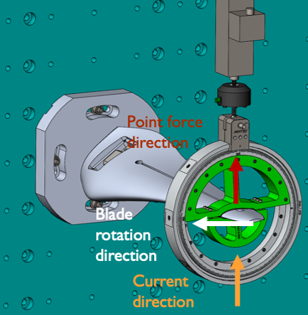

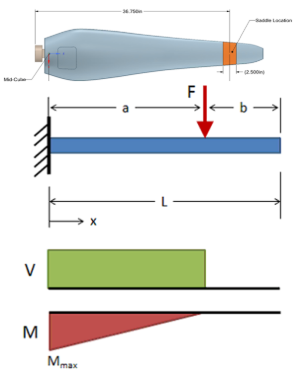

The blade root (below) inserts inside the blade and mounts the blade to the hub. This interface contains a thin-walled, cuboid section with circular hole through the center for cable routing.

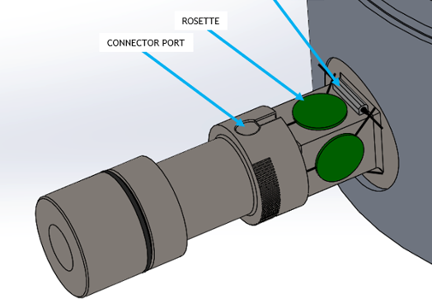

Four, 90 degree strain rosettes (top, bottom, left, right) are mounted to the outer flat surfaces of the thin-walled cuboid. Each strain rosette has a local coordinate system, denoted in the figure below. The global coordinate system corresponds to the blade orientation. The strain gauges are calibrated using the known load and measured strain at the blade root.

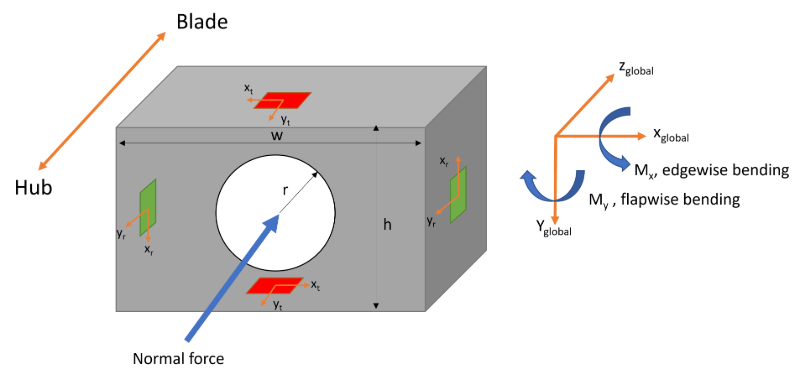

We will start by importing the necessary python packages (`pandas`, `xarray`, `numpy` ``matplotlib.pyplot``). Due to the highly variable nature of experimental configurations, these functions are not included in an MHKiT module. This example can be used as a guide to process strain data from other experimental configurations. Pandas is used to read the CSV file robustly. xarray is used to handle the multidimensional data easily. 

<sup>1</sup>Gunawan, Budi, et al. "Calibration Of Fiber Optic Rosette Sensors For Measuring Bending Moment On Tidal Turbine Blades." International Conference on Ocean Energy, Melbourne, Australia, September 17 – 19, 2024.

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## Load strain data and map rosettes to TBLR (top, bottom, left, right)
The strain data is contained in a CSV file. Time is the first column. Strain data is ordered by rosette and each rosette corresponds to three strain measurements (ea, eb, ec). Rosettes 1, 2, 3, 4 correspond to the top, bottom, left, and right rosettes in the global coordinate system.

In [2]:
raw_data = pd.read_csv(
    "data/strain/R17.csv",
    sep=",",
    header=None,
    index_col=0,
    names=[
        "time",
        "ea_1",
        "eb_1",
        "ec_1",
        "ea_2",
        "eb_2",
        "ec_2",
        "ea_3",
        "eb_3",
        "ec_3",
        "ea_4",
        "eb_4",
        "ec_4",
    ],
)

raw_data

,ea_1,eb_1,ec_1,ea_2,eb_2,ec_2,ea_3,eb_3,ec_3,ea_4,eb_4,ec_4
time,,,,,,,,,,,,
0.00,0.379,0.208,2.926,-0.623,1.160,0.270,0.309,1.877,-0.038,2.376,-0.312,-1.811
0.01,-2.578,1.360,1.523,0.192,-1.943,1.429,3.128,1.372,1.539,0.018,0.689,-1.305
0.02,0.839,1.862,2.198,-0.820,-1.347,0.785,1.124,2.687,0.594,0.370,-0.465,0.039
0.03,-5.249,-0.961,1.248,-0.881,-1.231,1.252,0.893,0.718,0.024,0.654,0.489,0.989
0.04,-3.377,1.078,2.092,-0.504,-0.504,1.268,-0.821,-0.989,0.577,-4.508,-0.312,0.514
...,...,...,...,...,...,...,...,...,...,...,...,...
1407.35,13.287,3.473,-18.279,-2.061,-0.428,5.256,25.280,11.563,25.195,-0.634,-21.175,-37.170
1407.36,16.541,5.171,-18.800,-3.036,-5.307,7.300,23.141,14.141,26.548,-2.776,-20.132,-35.298
1407.37,16.722,5.529,-15.892,-2.061,-4.517,6.495,22.500,13.679,25.744,-1.433,-19.965,-38.288


In [3]:
# Map all strain data to an xarray Dataset with variables ea, eb, ec with dimensions time, rosette
# Create an additional coordinate "rosetteName" for the "rosette" dimension to better keep track of rosette position in the global coordinate system.
data = xr.Dataset(data_vars={"ea": (['time','rosette'], raw_data[['ea_1', 'ea_2', 'ea_3', 'ea_4']]),
                             "eb": (['time','rosette'], raw_data[['eb_1', 'eb_2', 'eb_3', 'eb_4']]),
                             "ec": (['time','rosette'], raw_data[['ec_1', 'ec_2', 'ec_3', 'ec_4']]),
                            },
                 coords = {"time": raw_data.index,
                           "rosette": [1, 2, 3, 4],
                           "rosetteName": ("rosette", ["top", "bottom", "left", "right"]),
                          },
                 )

# Convert microstrain to strain
data[["ea","eb","ec"]] *= 1e-6

data

<xarray.Dataset> Size: 15MB
Dimensions:      (time: 140740, rosette: 4)
Coordinates:
  * time         (time) float64 1MB 0.0 0.01 0.02 ... 1.407e+03 1.407e+03
  * rosette      (rosette) int64 32B 1 2 3 4
    rosetteName  (rosette) <U6 96B 'top' 'bottom' 'left' 'right'
Data variables:
    ea           (time, rosette) float64 5MB 3.79e-07 -6.23e-07 ... -1.606e-06
    eb           (time, rosette) float64 5MB 2.08e-07 1.16e-06 ... -2.114e-05
    ec           (time, rosette) float64 5MB 2.926e-06 2.7e-07 ... -3.896e-05

## Define system parameters


In [4]:
# Define the geometry of the cuboid in the blade root where strain gauges are attached.
width = 44.6024 / 1000  # width of cuboid [m]
height = 44.6024 / 1000  # height of cuboid [m]
radius = 15.24 / 1000  # radius of hole in the cuboid [m]
blade_span = 0.86868  # Span from strain rosettes to point of blade loading [m] 

# Material properties of the cuboid
elastic_modulus = 197e9  # [Pa]
shear_modulus = 77.4e9  # [Pa]

## Calculate axial and shear strain
### 90 degree rosettes
We now have all strain data contained in a convenient xarray Dataset with dimensions corresponding to time and rosette, and variables corresponding to measured strain. The local y-axis of each rosette corresponds to the global z-axis. Each rosette is locally oriented like the following coordinate system.

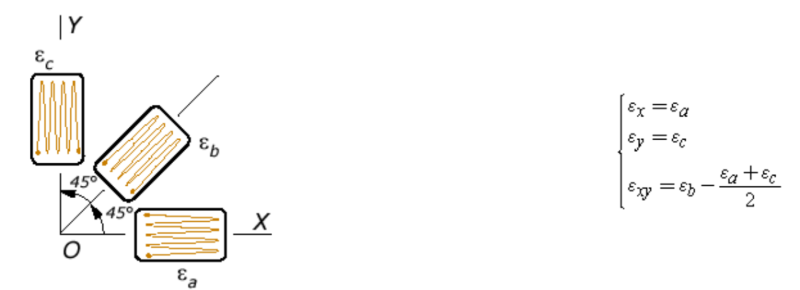

Now we can calculate the axial strains and shear strain for each 90 degree rosette. All rosettes are oriented in this way so a Dataset coordinate corresponding to rosette index is convenient here.

In [5]:
data["axial_strain_x"] = data["ea"]
data["axial_strain_y"] = data["ec"]
data["shear_strain"] = data["eb"] - (data["ea"] + data["ec"]) / 2
data

<xarray.Dataset> Size: 28MB
Dimensions:         (time: 140740, rosette: 4)
Coordinates:
  * time            (time) float64 1MB 0.0 0.01 0.02 ... 1.407e+03 1.407e+03
  * rosette         (rosette) int64 32B 1 2 3 4
    rosetteName     (rosette) <U6 96B 'top' 'bottom' 'left' 'right'
Data variables:
    ea              (time, rosette) float64 5MB 3.79e-07 ... -1.606e-06
    eb              (time, rosette) float64 5MB 2.08e-07 1.16e-06 ... -2.114e-05
    ec              (time, rosette) float64 5MB 2.926e-06 2.7e-07 ... -3.896e-05
    axial_strain_x  (time, rosette) float64 5MB 3.79e-07 ... -1.606e-06
    axial_strain_y  (time, rosette) float64 5MB 2.926e-06 2.7e-07 ... -3.896e-05
    shear_strain    (time, rosette) float64 5MB -1.445e-06 ... -8.57e-07

### Alternate equations for 120 degree rosettes
If we had 120 degree rosettes, we could calculate the axial and shear strains from the measured strains in a similar manner using the respective equations:

In [6]:
# Assuming eb aligns with the local y, and that ea and ec are +60 or -60 degrees from eb respectively.
# data["axial_strain_x"] = 2 / 3 * (data["ea"] - data["eb"] / 2 + data["ec"])
# data["axial_strain_y"] = data["eb"]
# data["shear_strain"] = 1 / np.sqrt(3) * (data["ea"] - data["ec"])

## Calculate loads from strain
### Define equations for normal force, moment, and torsion
Because the strain is measured on a rectangular prism, the normal force, moment and torsion use similar equations. We first create three functions that calculate the normal force, moment, and torsion given some strain and geometrical inputs. The torsion is calculated for each rosette. The normal force and moment are calculated using rosette pairs to eliminate the effect of the bending moment on axial strain when calculating the normal force, and vice versa.

In [7]:
def calculate_normal(axial_strain_1, axial_strain_2, elastic_modulus, shear_modulus, width, height, radius):
    normal = 0.5 * (axial_strain_1 + axial_strain_2) * \
             elastic_modulus * (width * height - np.pi * radius**2)
    return normal

def calculate_moment(axial_strain_1, axial_strain_2, elastic_modulus, shear_modulus, width, height, radius):
    moment = (axial_strain_1 - axial_strain_2) / height * \
             elastic_modulus * (width * height**3 / 12 - np.pi * radius**4 / 4)
    return moment

def calculate_torsion(shear_strain, shear_modulus, width, height, radius):
    polar_moment_of_inertia = (width**3 * height + width * height**3) / 12 - np.pi * radius**4 / 2
    torsion = shear_strain * shear_modulus * polar_moment_of_inertia / (height / 2)
    return torsion

### Calculate normal force and bending moments
We will use the three custom functions to calculate the normal force and bending moments with the top and bottom rosette pair, and then based on the left and right rosette pair.

In [8]:
# Top and bottom rosettes
data["normal_topBottom"] = calculate_normal(data.sel(rosette=1)["axial_strain_y"], data.sel(rosette=2)["axial_strain_y"], 
                                    elastic_modulus, shear_modulus, width, height, radius)
data["moment_x"] = calculate_moment(data.sel(rosette=1)["axial_strain_y"], data.sel(rosette=2)["axial_strain_y"], 
                            elastic_modulus, shear_modulus, width, height, radius)

# Right and left rosettes
# note that height and width inputs are switched due to the different orientation
data["normal_leftRight"] = calculate_normal(data.sel(rosette=3)["axial_strain_y"], data.sel(rosette=4)["axial_strain_y"], 
                                    elastic_modulus, shear_modulus, height, width, radius)
data["moment_y"] = calculate_moment(data.sel(rosette=3)["axial_strain_y"], data.sel(rosette=4)["axial_strain_y"], 
                            elastic_modulus, shear_modulus, height, width, radius)

### Calculate torsion
Next we will calculate the torsion using the shear strain of each rosette and find the average torsion load.

In [9]:
data["torsion_top"] = calculate_torsion(data.sel(rosette=1)["shear_strain"], shear_modulus, width, height, radius)
data["torsion_bottom"] = calculate_torsion(data.sel(rosette=2)["shear_strain"], shear_modulus, width, height, radius)

# note that height and width inputs are switched due to the different orientation
data["torsion_left"] = calculate_torsion(data.sel(rosette=3)["shear_strain"], shear_modulus, height, width, radius)
data["torsion_right"] = calculate_torsion(data.sel(rosette=4)["shear_strain"], shear_modulus, height, width, radius)

# Calculate the mean torsion
data["torsion_mean"] = (data["torsion_top"] + data["torsion_bottom"] + data["torsion_right"] + data["torsion_left"])/4

### Rotate loads to blade coordinate system
It is possible that the blade coordinate system is not aligned to the global coordinate system. This could be due to limitations of the experimental configuration or intentional to enable the use of strain gauges with larger loads.

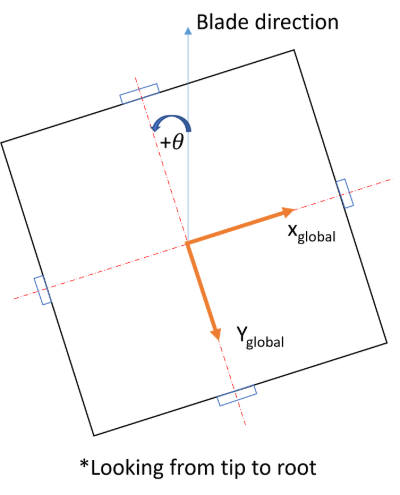

In this case, we can transform the bending moment from the global coordinate system to align with the blade's flapwise direction.

In [10]:
angle = 0 * np.pi / 180 # rotation angle of the root
data["moment_flapwise"] = data["moment_x"] * np.cos(angle) - data["moment_y"] * np.sin(angle)
data["moment_edgewise"] = data["moment_x"] * np.sin(angle) + data["moment_y"] * np.cos(angle)

### Visualize loads
We can now plot various quantities of interest, including the normal force at the blade root, flapwise and edgewise bending moments, equivalent load applied to the blade, and torsion. These quantities are then used to validate the experimental set-up using the known loads before advancing to an open-water test campaign.

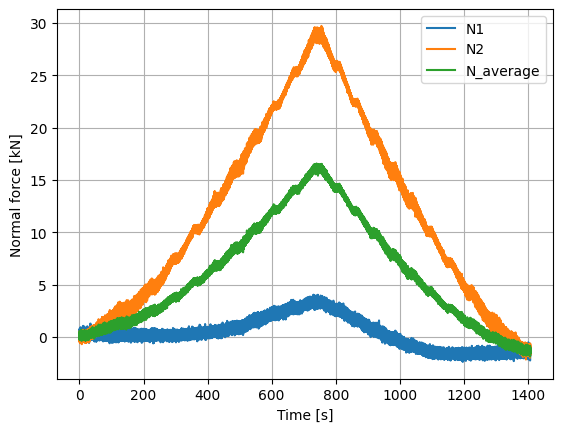

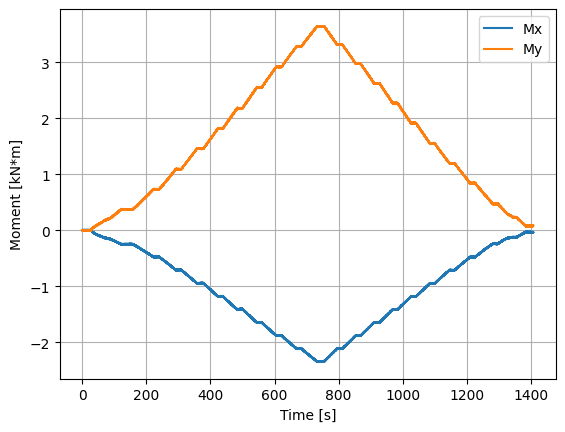

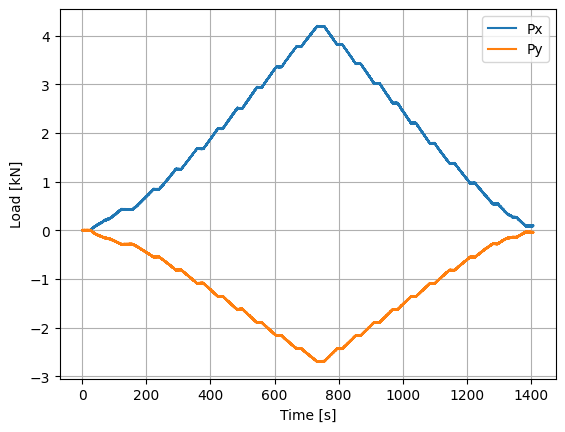

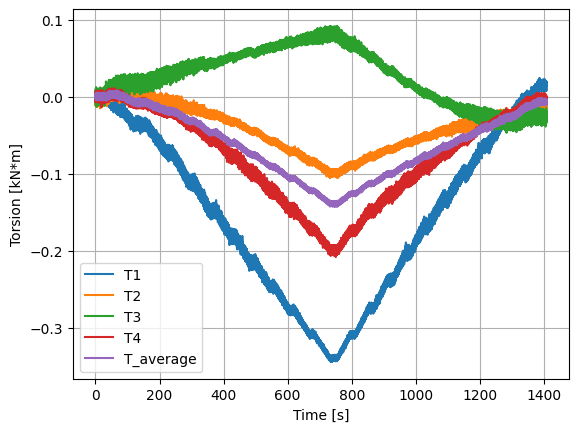

In [11]:
# Normal forces
(data["normal_topBottom"]/1000).plot()
(data["normal_leftRight"]/1000).plot()
((data["normal_topBottom"]+data["normal_leftRight"])/2000).plot()
plt.legend(['N1','N2','N_average'])
plt.ylabel('Normal force [kN]')
plt.xlabel('Time [s]')
plt.grid()

# Moment
plt.figure()
(data["moment_x"]/1000).plot()
(data["moment_y"]/1000).plot()
plt.legend(['Mx','My'])
plt.ylabel('Moment [kN*m]')
plt.xlabel('Time [s]')
plt.grid()

# Blade load
plt.figure()
(data["moment_y"]/(blade_span*1000)).plot()
(data["moment_x"]/(blade_span*1000)).plot()
plt.legend(['Px','Py'])
plt.ylabel('Load [kN]')
plt.xlabel('Time [s]')
plt.grid()

# Torsion
plt.figure()
(data["torsion_top"]/1000).plot()
(data["torsion_bottom"]/1000).plot()
(data["torsion_left"]/1000).plot()
(data["torsion_right"]/1000).plot()
(data["torsion_mean"]/1000).plot()
plt.legend(["T1", "T2", "T3", "T4", "T_average"])
plt.ylabel('Torsion [kN*m]')
plt.xlabel('Time [s]')
plt.grid()